In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import cnames
from itertools import cycle
from bokeh.plotting import output_notebook, output_file, figure, show, ColumnDataSource
from bokeh.models import HoverTool
import warnings

warnings.filterwarnings(action='ignore')
output_notebook()
%matplotlib inline

Loading BokehJS ...

### PCA and select important features

In [2]:
from utils.pca_utils import *

Number of features: 255

*--- PCA Report ---*

X mean:		-10.235
X variance:	2047.605

...Rescaling data...

X_scaled mean:		-0.000
X_scaled variance:	1.000


 -- Summary --
You can reduce from 255 to 12 dimensions while retaining 95% of variance.
You can reduce from 255 to 4 dimensions while retaining 80% of variance.
2 principal components explain 72.20% of variance.
3 principal components explain 79.80% of variance.


X*X_pca: (255, 420) * (420, 255) = (255, 255)
        score_           feature_
rank                             
1     1.722567    Mel_Band_2_mean
2     1.590665    Mel_Band_3_mean
3     1.480631    Mel_Band_8_mean
4     1.479637    Mel_Band_9_mean
5     1.461562   Mel_Band_10_mean
...        ...                ...
251   0.695315    Mel_Band_38_std
252   0.691361   Mel_Band_93_mean
253   0.682499   Mel_Band_128_std
254   0.635274  Mel_Band_127_mean
255   0.429415  Mel_Band_128_mean

[255 rows x 2 columns]


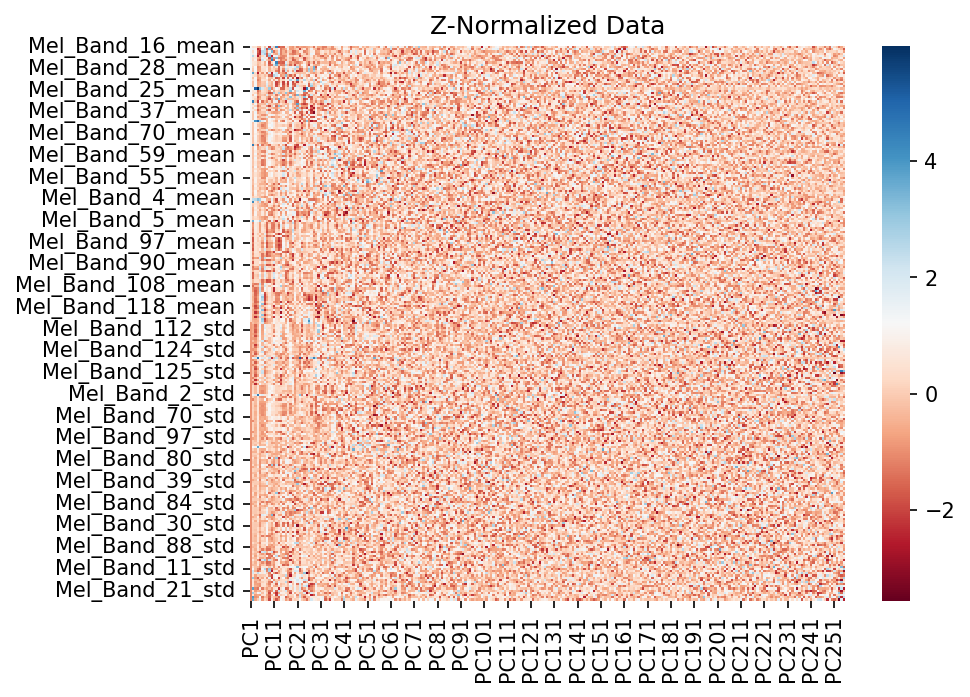

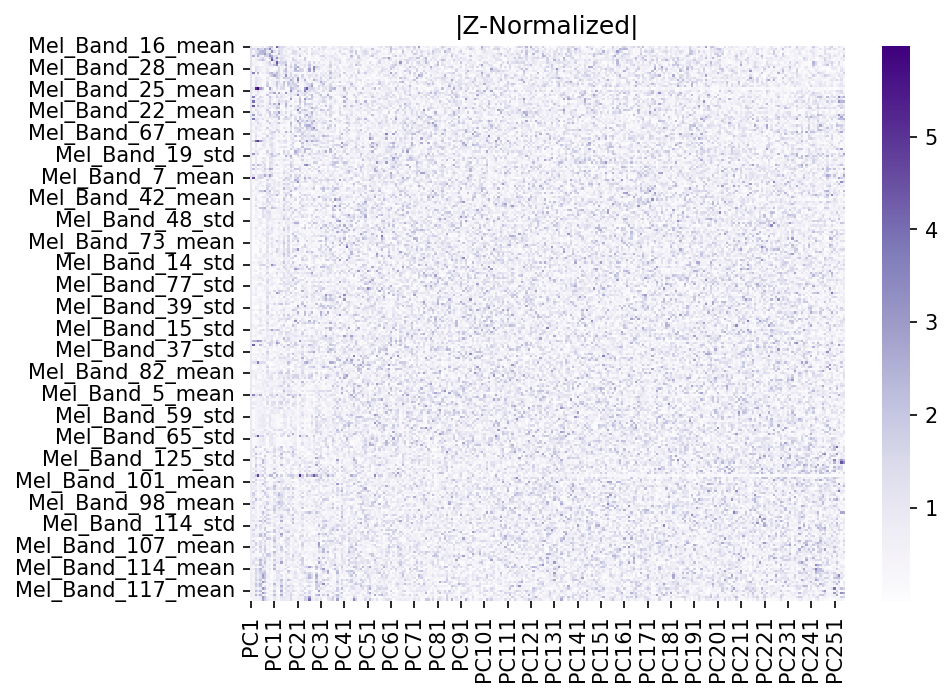

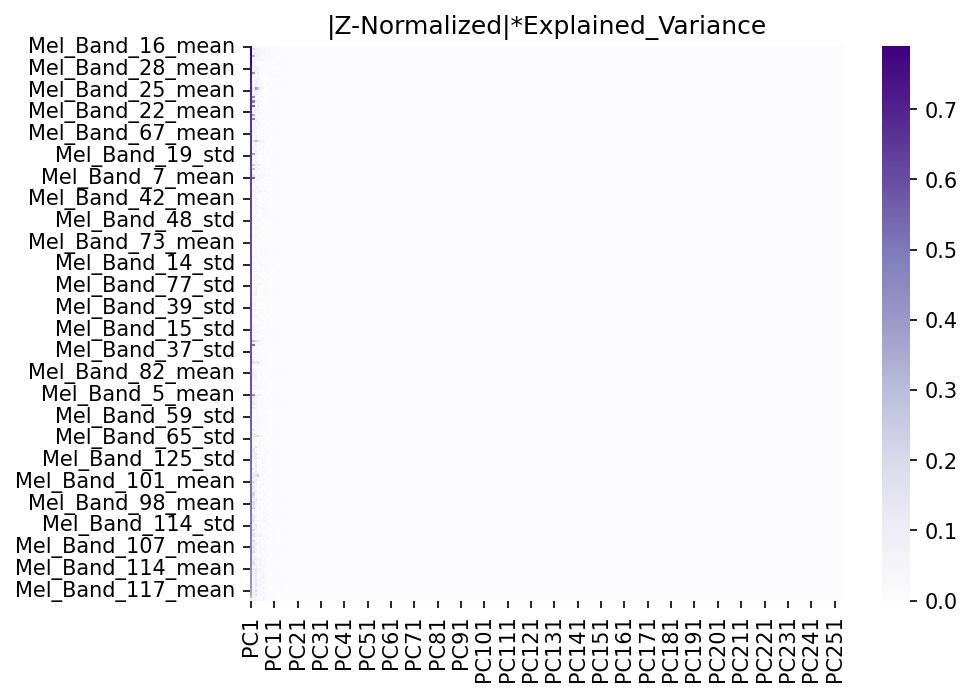

In [3]:
# NOTE: clustering
# using https://medium.com/@gaurav_bio/creating-visualizations-to-better-understand-your-data-and-models-part-1-a51e7e5af9c0
df = pd.read_excel("./outputs/output_mel_feature_stats.xlsx")
# Assume that features start from the 5th column onward
features = df.iloc[:, 7:]

print(f"Number of features: {features.shape[1]}")

outputs = pca_full_report(features.values, features.columns, save_plot=True)
outputs[-1].to_excel("./outputs/feature_ranking.xlsx")

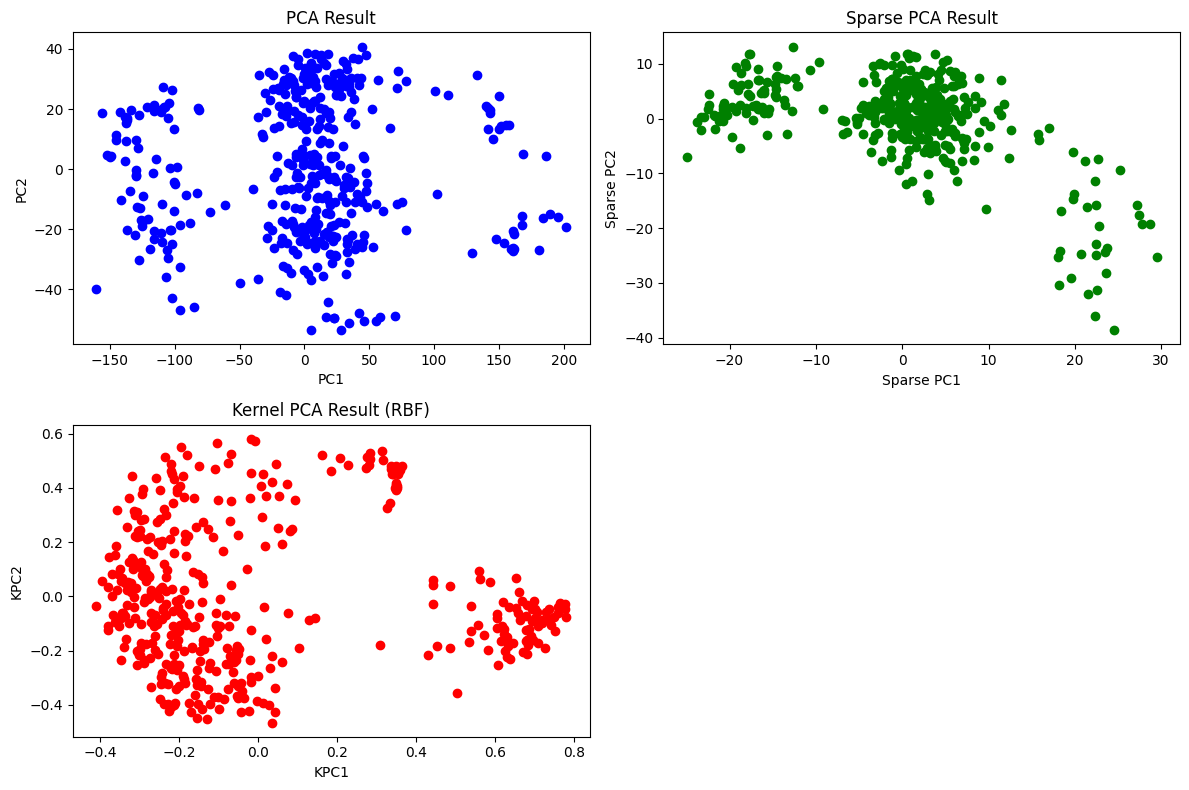

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, SparsePCA
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt

# Assume df is your DataFrame
# Example: Let's create a random DataFrame for demonstration
# Replace this with your own data

df = pd.read_excel("./outputs/output_mel_feature_stats.xlsx")
# Assume that features start from the 5th column onward
features = df.iloc[:, 7:]

# Step 1: Preprocess Data (Standardization)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(features)

# Step 2: PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features.values)

# Step 3: Sparse PCA
sparse_pca = SparsePCA(n_components=2, random_state=42)
sparse_pca_result = sparse_pca.fit_transform(data_scaled)

# Step 4: Kernel PCA (use 'rbf' kernel here as an example)
kernel_pca = KernelPCA(n_components=2, kernel="rbf")
kernel_pca_result = kernel_pca.fit_transform(data_scaled)

# Step 5: Plot and Compare Results

# Explained variance for PCA
explained_variance = pca.explained_variance_ratio_

# Plot PCA results
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c="blue", label="PCA")
plt.title("PCA Result")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.subplot(2, 2, 2)
plt.scatter(sparse_pca_result[:, 0], sparse_pca_result[:, 1], c="green", label="Sparse PCA")
plt.title("Sparse PCA Result")
plt.xlabel("Sparse PC1")
plt.ylabel("Sparse PC2")

plt.subplot(2, 2, 3)
plt.scatter(kernel_pca_result[:, 0], kernel_pca_result[:, 1], c="red", label="Kernel PCA")
plt.title("Kernel PCA Result (RBF)")
plt.xlabel("KPC1")
plt.ylabel("KPC2")

plt.tight_layout()
plt.show()

### Clustering and select voice

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# cSpell: ignore tsne xlabel ylabel figsize cmap fontsize ha viridis colorbar edgecolors

# Function to perform PCA, then t-SNE, and visualize the clusters with numbers
def visualize_tsne_with_clusters(df, data, title, k = 10):

    # Step 2: Perform t-SNE on the PCA-reduced features
    tsne = TSNE(n_components=2, random_state=42, perplexity=50, n_iter=5000, verbose=1)
    tsne_results = tsne.fit_transform(data)
    df["TSNE_1"] = tsne_results[:, 0]
    df["TSNE_2"] = tsne_results[:, 1]

    # Plot the t-SNE results
    plt.figure(figsize=(10, 8))

    # Scatter plot of t-SNE results
    scatter = plt.scatter(
        tsne_results[:, 0], tsne_results[:, 1], c=df["Cluster"], cmap="viridis", s=50
    )

    # Annotate each point with the cluster number
    for i, label in enumerate(df["Cluster"]):
        plt.text(tsne_results[i, 0], tsne_results[i, 1], str(label), fontsize=6, ha="right")

    # Plot the centroids of each cluster
    for cluster in range(k):
        print(cluster)
        cluster_data = df[df["Cluster"] == cluster]
        male_data = cluster_data[cluster_data["Gender"] == 1]
        female_data = cluster_data[cluster_data["Gender"] == 0]
        print(len(male_data), len(female_data))

        tsne_cluster_data = tsne_results[df["Cluster"] == cluster]

        # Calculate the centroid
        centroid = tsne_cluster_data.mean(axis=0)

        # Plot the centroid
        plt.scatter(
            centroid[0],
            centroid[1],
            c="red",
            marker="^",
            s=100,
            label=f"Cluster {cluster} Centroid",
        )

        # # Highlight the closest point to the centroid
        # closest_idx = ((tsne_cluster_data - centroid) ** 2).sum(axis=1).argmin()
        # # print(f"Closest point to centroid of cluster {cluster}: {cluster_data.iloc[closest_idx]}")
        # closest_point = tsne_cluster_data[closest_idx]

        # plt.scatter(
        #     closest_point[0],
        #     closest_point[1],
        #     c="blue",
        #     marker="o",
        #     edgecolors="black",
        #     s=150,
        #     label=f"Closest in Cluster {cluster}",
        # )

        # Compute distances from each gender group to the cluster center
        # Highlight the closest male and female points to the centroid

        if not male_data.empty:
            male_tsne_data = male_data.iloc[:, -2:]
            closest_male_idx = ((male_tsne_data - centroid) ** 2).sum(axis=1).argmin()
            closest_male_point = male_tsne_data.iloc[closest_male_idx]
            plt.scatter(
                closest_male_point[0],
                closest_male_point[1],
                c="brown",
                marker="s",
                edgecolors="black",
                s=150,
                label=f"Closest Male in Cluster {cluster}",
            )
            print(
                male_data[["short_name", "Gender", "Pitch shifted", "Speed changed"]].iloc[closest_male_idx],
                "\n",
            )

        if not female_data.empty:
            female_tsne_data = female_data.iloc[:, -2:]
            closest_female_idx = ((female_tsne_data - centroid) ** 2).sum(axis=1).argmin()
            closest_female_point = female_tsne_data.iloc[closest_female_idx]
            plt.scatter(
                closest_female_point[0],
                closest_female_point[1],
                c="pink",
                marker="o",
                edgecolors="black",
                s=150,
                label=f"Closest Male in Cluster {cluster}",
            )
            print(
                female_data[["short_name", "Gender", "Pitch shifted", "Speed changed"]].iloc[
                    closest_female_idx
                ],
                "\n",
            )

        # draw a circle around the centroid
        radius = cdist(tsne_cluster_data, [centroid]).max()
        circle = plt.Circle(centroid, radius, color='black', fill=False, linestyle='--', linewidth=1)
        plt.gca().add_patch(circle)

    plt.title(f"t-SNE Visualization with Centroids of {title}")
    plt.colorbar(scatter, label="Cluster")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    # plt.legend(False)
    plt.grid(True)
    plt.show()

Initialization complete
Iteration 0, inertia 630711.7589035926.
Iteration 1, inertia 426591.280904983.
Iteration 2, inertia 412750.461479779.
Iteration 3, inertia 409413.93522479583.
Iteration 4, inertia 408108.44433801435.
Iteration 5, inertia 407549.36575317534.
Iteration 6, inertia 407475.33785575896.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 634476.772880161.
Iteration 1, inertia 421990.2032228012.
Iteration 2, inertia 408232.2779828997.
Iteration 3, inertia 402234.1710028554.
Iteration 4, inertia 400680.669654508.
Iteration 5, inertia 399944.9498489002.
Iteration 6, inertia 399588.14271851775.
Iteration 7, inertia 399066.0710839071.
Iteration 8, inertia 398917.95380961173.
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 639552.6924122496.
Iteration 1, inertia 446399.199208947.
Iteration 2, inertia 431096.63107347686.
Iteration 3, inertia 424762.65261809935.
Iteration 4, inertia 420722.98217

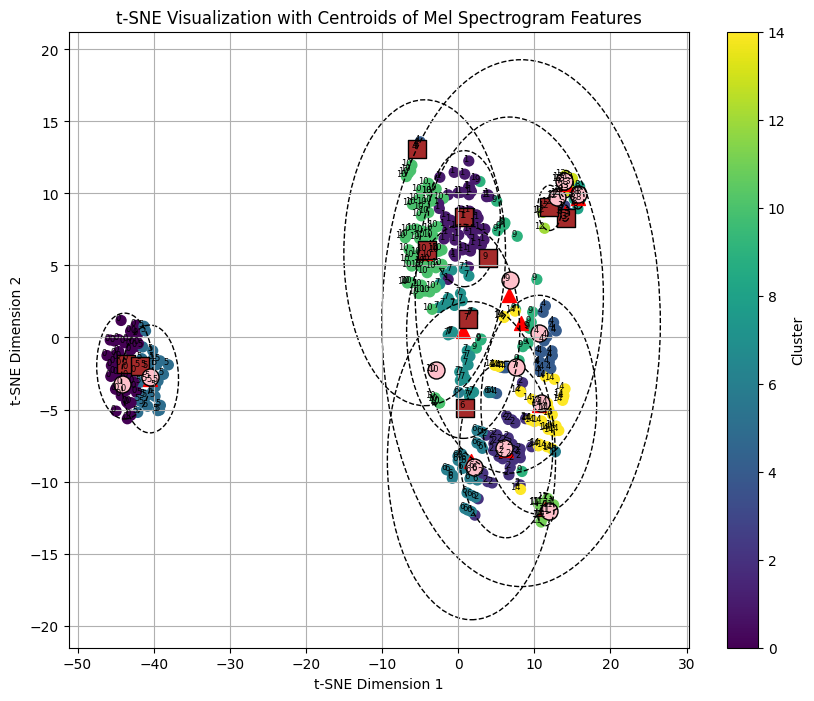

Cluster
0     45
1     49
2     38
3      8
4     29
5     31
6     33
7     33
8      8
9     22
10    60
11    12
12     7
13    10
14    35
Name: count, dtype: int64


In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd

df = pd.read_excel("./outputs/output_mel_feature_stats.xlsx")

features = df.iloc[:, 6:]
features_normalized = StandardScaler().fit_transform(features)

data  = features
n_clusters = 15
df_copy = df.copy()

k_means = KMeans(
    n_clusters=n_clusters,
    init="k-means++",
    max_iter=int(1e8),
    n_init=10,
    verbose=1,
    random_state=42,
)

df["Cluster"] = k_means.fit_predict(data)

df.to_excel("./outputs/output_feature_stats_clusters.xlsx")

visualize_tsne_with_clusters(df, data, "Mel Spectrogram Features", k=n_clusters)
print(df["Cluster"].value_counts().sort_index())
# f"{row['short_name']} (Pitch: {row['Pitch shifted'] if row['Pitch shifted'] != 0 else 100}, Speed: {row['Speed changed'] if row['Speed changed'] != 0 else 100})"

In [14]:
# draft from copilot
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances_argmin_min

df = pd.read_excel("./outputs/output_mel_feature_stats.xlsx")

mel_features = df.iloc[:, 6:]
mel_features_normalized = StandardScaler().fit_transform(mel_features)

df_copy = df.copy()

k_means = KMeans(
    n_clusters=15, init="k-means++", max_iter=int(1e8), n_init=1, verbose=1, random_state=42
)

df["Cluster"] = k_means.fit_predict(mel_features_normalized)


# Function to find the closest data points to the cluster centers
def find_closest_data(df, mel_features_normalized, k_means):
    closest_data = {}
    for cluster in range(k_means.n_clusters):
        cluster_data = df[df["Cluster"] == cluster]
        cluster_features = mel_features_normalized[df["Cluster"] == cluster]
        cluster_center = k_means.cluster_centers_[cluster].reshape(1, -1)
        closest_index, _ = pairwise_distances_argmin_min(cluster_center, cluster_features)
        closest_data[cluster] = cluster_data.iloc[closest_index[0]]
    return closest_data


# Filter data by gender
df_male = df[df["Gender"] == 1].copy()
df_female = df[df["Gender"] == 0].copy()

# Find the closest data points for male and female
closest_male_data = find_closest_data(df_male, mel_features_normalized[df["Gender"] == 1], k_means)
closest_female_data = find_closest_data(
    df_female, mel_features_normalized[df["Gender"] == 0], k_means
)

# Print the closest data points
print("Closest male data points to cluster centers:")
for cluster, data in closest_male_data.items():
    print(f"Cluster {cluster}: {data}")

print("\nClosest female data points to cluster centers:")
for cluster, data in closest_female_data.items():
    print(f"Cluster {cluster}: {data}")

visualize_tsne_with_clusters(df, mel_features_normalized, "Mel Spectrogram Features")
print(df["Cluster"].value_counts().sort_index())

Initialization complete
Iteration 0, inertia 38300.82133792456.
Iteration 1, inertia 28456.146987046624.
Iteration 2, inertia 27756.29102585325.
Iteration 3, inertia 27128.51346029653.
Iteration 4, inertia 26713.739212856683.
Iteration 5, inertia 26527.373497933062.
Iteration 6, inertia 26476.958697006816.
Iteration 7, inertia 26359.05068259452.
Iteration 8, inertia 26298.771876338822.
Iteration 9, inertia 26275.5675480367.
Iteration 10, inertia 26269.16015618775.
Iteration 11, inertia 26267.35593008121.
Converged at iteration 11: strict convergence.


ValueError: Found array with 0 sample(s) (shape=(0, 256)) while a minimum of 1 is required by check_pairwise_arrays.

In [ ]:
# Select K for k-means clustering
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from tqdm import tqdm


# Function to compute Inertia and Silhouette Score for different numbers of clusters
def find_optimal_clusters_kmeans(data, max_clusters=10):
    # Normalize the data
    scaler = StandardScaler()
    data_normalized = scaler.fit_transform(data)

    inertia = []
    silhouette_scores = []
    n_clusters_range = range(
        2, max_clusters + 1
    )  # Start from 2 because silhouette needs at least 2 clusters

    for k in tqdm(n_clusters_range):
        # Fit K-Means with k clusters
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data_normalized)

        # Append inertia (sum of squared distances)
        inertia.append(kmeans.inertia_)

        # Compute and append silhouette score (only if there are more than 1 cluster)
        silhouette_scores.append(silhouette_score(data_normalized, kmeans.labels_))

    # Plot the Elbow Method (Inertia) and Silhouette Score
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = "tab:blue"
    ax1.set_xlabel("Number of Clusters (k)")
    ax1.set_ylabel("Inertia", color=color)
    ax1.plot(n_clusters_range, inertia, label="Inertia", marker="o", color=color)
    ax1.tick_params(axis="y", labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axis that shares the same x-axis
    color = "tab:red"
    ax2.set_ylabel("Silhouette Score", color=color)
    ax2.plot(
        n_clusters_range, silhouette_scores, label="Silhouette Score", marker="o", color=color
    )
    ax2.tick_params(axis="y", labelcolor=color)

    fig.tight_layout()  # to prevent label overlap
    plt.title("Elbow Method and Silhouette Score for K-Means")
    plt.show()

    # Return both lists for further analysis
    return inertia, silhouette_scores


def select_k(inertia, silhouette_scores, n_clusters_range):
    # Find the k with the maximum silhouette score
    optimal_k_silhouette = n_clusters_range[np.argmax(silhouette_scores)]

    # Find the elbow point in inertia (you can use heuristics or gradient-based approaches)
    # In this example, we are manually finding it, but there are methods to automate this.
    optimal_k_inertia = n_clusters_range[np.argmin(np.diff(inertia)) + 1]  # Simple elbow detection

    return optimal_k_silhouette, optimal_k_inertia

In [14]:
# select n for Gaussian Mixture Model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm


# Function to compute BIC and AIC for different numbers of clusters
def find_optimal_clusters_gmm(data, max_clusters=10):
    # Normalize the data
    scaler = StandardScaler()
    data_normalized = scaler.fit_transform(data)

    bic = []
    aic = []
    n_components = range(1, max_clusters + 1)

    for n in tqdm(n_components):
        # Fit the GMM with n components (clusters)
        gmm = GaussianMixture(n_components=n, random_state=42)
        gmm.fit(data_normalized)

        # Append BIC and AIC values
        bic.append(gmm.bic(data_normalized))
        aic.append(gmm.aic(data_normalized))

    # Plot the BIC and AIC scores
    plt.figure(figsize=(10, 6))
    plt.plot(n_components, bic, label="BIC", marker="o")
    plt.plot(n_components, aic, label="AIC", marker="o")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Information Criterion")
    plt.title("AIC for GMM")
    plt.legend()
    plt.show()

    # Return both lists for further analysis
    return bic, aic

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 420 samples in 0.001s...
[t-SNE] Computed neighbors for 420 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 420 / 420
[t-SNE] Mean sigma: 24.044879
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.383492
[t-SNE] KL divergence after 1850 iterations: 0.351354
0
24 62
short_name       en-HK-SamNeural
Gender                         1
Pitch shifted                100
Speed changed                100
Name: 150, dtype: object 

short_name       en-AU-AnnetteNeural
Gender                             0
Pitch shifted                    100
Speed changed                    100
Name: 4, dtype: object 

1
37 39
short_name       en-IE-ConnorNeural
Gender                            1
Pitch shifted                   100
Speed changed                   100
Name: 163, dtype: object 

short_name       en-IN-KavyaNeural
Gender                           0
Pitch shifted                  100
Speed chan

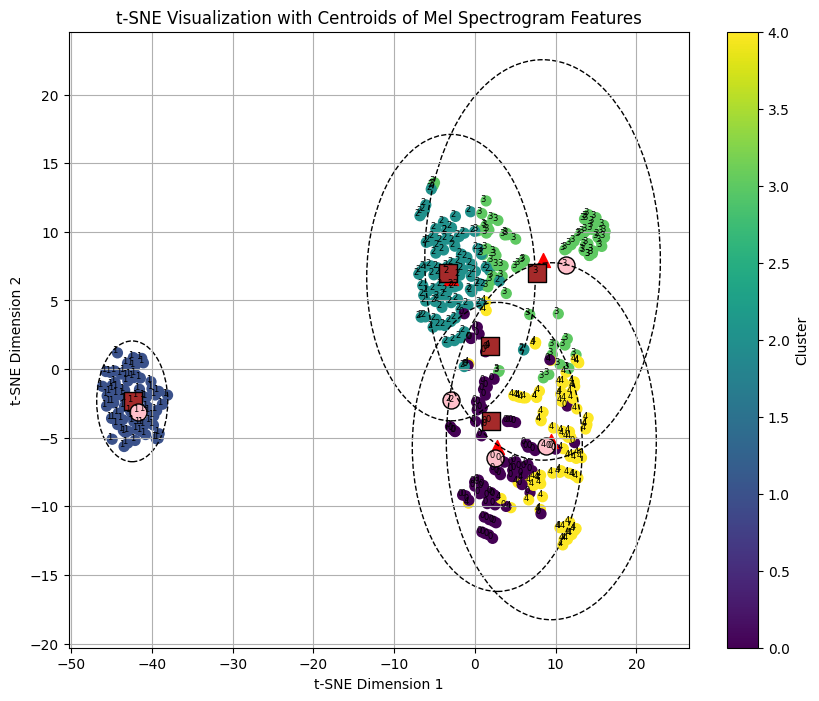

Cluster
0    86
1    76
2    92
3    79
4    87
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import pairwise_distances_argmin_min
import numpy as np
import pandas as pd

# cSpell: ignore argmin iloc tsne

df = pd.read_excel("./outputs/output_mel_feature_stats.xlsx")

features = df.iloc[:, 6:]  # Assuming features start at 7th column (index 6)
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

data = features

# bic, aic = find_optimal_clusters_gmm(data, max_clusters=30)
# # Perform GMM clustering on the entire dataset
# optimal_clusters = np.argmin(aic) + 1  # Add 1 because range starts from 1
optimal_clusters = 5
gmm = GaussianMixture(
    n_components=optimal_clusters,
    tol=1e-6,
    init_params="k-means++",  # Corrected from "k-means++"
    max_iter=int(1e8),
    n_init=10000,
    verbose=0,
    verbose_interval=10,
    random_state=42,
).fit(data)

df["Cluster"] = gmm.predict(data)

visualize_tsne_with_clusters(df, data, "Mel Spectrogram Features", k=optimal_clusters)

# count number of clusters
print(df["Cluster"].value_counts().sort_index())

In [13]:
import numpy as np

# Calculate the center of the feature space
center = np.mean(data, axis=0)

# Filter data by gender
df_male = df[df["Gender"] == 1].copy()
df_female = df[df["Gender"] == 0].copy()


# Find the closest data points to the center for each gender
def find_closest_to_center(df, center, scaler):
    features = df.iloc[:, 6:-1]
    features_normalized = scaler.transform(mel_features)
    
    closest_index, _ = pairwise_distances_argmin_min([center], features)
    return df.iloc[closest_index[0]]


closest_male = find_closest_to_center(df_male, center, scaler)
closest_female = find_closest_to_center(df_female, center, scaler)

# Find the closest female in the same cluster as the closest male
cluster_of_closest_male = closest_male["Cluster"]
df_female_same_cluster = df_female[df_female["Cluster"] == cluster_of_closest_male]
closest_female_same_cluster = find_closest_to_center(df_female_same_cluster, center, scaler)

print("Closest male data point to the center of the feature space:")
print(closest_male)

print("\nClosest female data point to the center of the feature space:")
print(closest_female)

print("\nClosest female data point in the same cluster as the closest male:")
print(closest_female_same_cluster)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- chroma_10_mean
- chroma_10_std
- chroma_11_mean
- chroma_11_std
- chroma_12_mean
- ...
Feature names seen at fit time, yet now missing:
- Mel_Band_100_mean
- Mel_Band_100_std
- Mel_Band_101_mean
- Mel_Band_101_std
- Mel_Band_102_mean
- ...
